<a href="https://colab.research.google.com/github/AMefleh/practice_projects/blob/main/HW5_PySpark_(Abdallah_Al_Mefleh).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Your Name: Abdallah Al-Mefleh


**How to start?**
1. I only gave you the view permission. Thus you cannot modify this colab file directly.
2. Instead, you should make a copy of your own. Click the menu "File", and then click "Save a Copy in Drive"
3. By default, your saved copy is located in your google drive folder "My Drive/Colab Notebooks". You can go to the URL "https://drive.google.com/" to access your google drive folder.  

**Submission Instruction**:
1. Make sure that this page contains the output of your program. If you are not sure, click the menu "Runtime", and then click "Run all".
2. Print the page to a pdf file. Click the menu "File", and then "Print".
3. Submit the pdf file to Brightspace before the deadline.

# Market Basket Analysis

In this homework, we will use the [Instacart Market Basket dataset](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data).

The dataset contains 3 Million Instacart Orders.

## Prepare running environment

In [1]:
!pip install --upgrade --quiet pyspark
!pip install --upgrade --quiet PyDrive
!apt install openjdk-8-jdk-headless -qqq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done




In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Load the datasets

Download the data directly from Google drive.

In [7]:
id='1W3U7CTWHJydKf6FsnAHP6o5Tz4OwQ7LJ'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('products.csv')

id='17RPt-kC9uZGNPgJ4DpAnH40XL6hHtp0L'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('order_products__train.csv')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [9]:
spark = SparkSession\
  .builder\
  .appName("Instacart ")\
  .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [10]:
products = spark.read.csv('products.csv', header=True, inferSchema=True)
orders = spark.read.csv('order_products__train.csv', header=True, inferSchema=True)

In [11]:
products.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)



In [12]:
orders.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)



* add_to_cart_order: order in which each product was added to cart
* reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

In [13]:
products.show(n=5)

+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
|         1|Chocolate Sandwic...|      61|           19|
|         2|    All-Seasons Salt|     104|           13|
|         3|Robust Golden Uns...|      94|            7|
|         4|Smart Ones Classi...|      38|            1|
|         5|Green Chile Anyti...|       5|           13|
+----------+--------------------+--------+-------------+
only showing top 5 rows



In [14]:
orders.show(n=5)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows



# Part 1: Solve the following questions using SQL DataFrame APIs.

## Question 1: Find out how many products?

In [17]:
# Your code here:
# hint: count()
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.GroupedData.count.html

productCount = products.count()
print(f'Total number of products - {productCount}')

Total number of products - 49688


## Question 2: Compute how many items in each order

In [18]:
# Your code here:
# Hint: groupBy()
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html

itemsPerOrder = orders.groupBy('order_id').count()
itemsPerOrder.show(5)

+--------+-----+
|order_id|count|
+--------+-----+
|    1342|    8|
|    1591|   31|
|    4519|    1|
|    4935|    1|
|    6357|    9|
+--------+-----+
only showing top 5 rows



## Question 3: Compute how many orders was made for each product.

In [19]:
# Your code here:
# Hints: groupby(), count()

ordersPerProduct = orders.groupBy('product_id').count()
ordersPerProduct = ordersPerProduct.withColumnRenamed('count', 'order_count')
ordersPerProduct.show(5)

+----------+-----------+
|product_id|order_count|
+----------+-----------+
|     25591|         25|
|      7754|          9|
|     47501|         11|
|     37307|        122|
|      4818|         19|
+----------+-----------+
only showing top 5 rows



## Question 4: Show the product_id of the top five most popular products.

In [20]:
# Your code here:
# Hints: groupby(), count(), orderBy()
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html

ordersPerProduct = orders.groupBy('product_id').count()
ordersPerProduct = ordersPerProduct.withColumnRenamed('count', 'order_count')
topFiveProducts = ordersPerProduct.orderBy(desc('order_count')).limit(5)
topFiveProducts.show()

+----------+-----------+
|product_id|order_count|
+----------+-----------+
|     24852|      18726|
|     13176|      15480|
|     21137|      10894|
|     21903|       9784|
|     47626|       8135|
+----------+-----------+



## Question 5: Build a new dataframe that has two columns: order_id, product_name

In [21]:
# Your code here:
# Hint: join
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.join.html

orderProductNames = orders.join(products, on='product_id')
orderProductNames = orderProductNames.select('order_id', 'product_name')
orderProductNames.show(5)

+--------+--------------------+
|order_id|        product_name|
+--------+--------------------+
|       1|    Bulgarian Yogurt|
|       1|Organic 4% Milk F...|
|       1|Organic Celery He...|
|       1|      Cucumber Kirby|
|       1|Lightly Smoked Sa...|
+--------+--------------------+
only showing top 5 rows



## Question 6: Show the product name of the top five most popular products.

In [22]:
# Your code here:

ordersPerProduct = orders.groupBy('product_id').count()
ordersPerProduct = ordersPerProduct.withColumnRenamed('count', 'order_count')
topFiveProducts = ordersPerProduct.orderBy(desc('order_count')).limit(5)
topFiveProductNames = topFiveProducts.join(products, on='product_id')
topFiveProductNames = topFiveProductNames.select('product_name', 'order_count')
topFiveProductNames.show()

+--------------------+-----------+
|        product_name|order_count|
+--------------------+-----------+
|Bag of Organic Ba...|      15480|
|Organic Strawberries|      10894|
|Organic Baby Spinach|       9784|
|              Banana|      18726|
|         Large Lemon|       8135|
+--------------------+-----------+



# Part 2: Running SQL Queries Programmatically


In [23]:
# Create Temporary Tables to work using sql like commands
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

SQL can be run over DataFrames that have been registered as a table. For example:

In [24]:
results = spark.sql("SELECT product_id FROM orders")
results.show(5)

+----------+
|product_id|
+----------+
|     49302|
|     11109|
|     10246|
|     49683|
|     43633|
+----------+
only showing top 5 rows



In [25]:
results = spark.sql("SELECT order_id,COUNT(product_id) AS total_items FROM orders GROUP BY order_id")
results_pd = results.toPandas()
results_pd.head()

,order_id,total_items
0,1342,8
1,1591,31
2,4519,1
3,4935,1
4,6357,9


Plot the histogram of the total items of all orders.

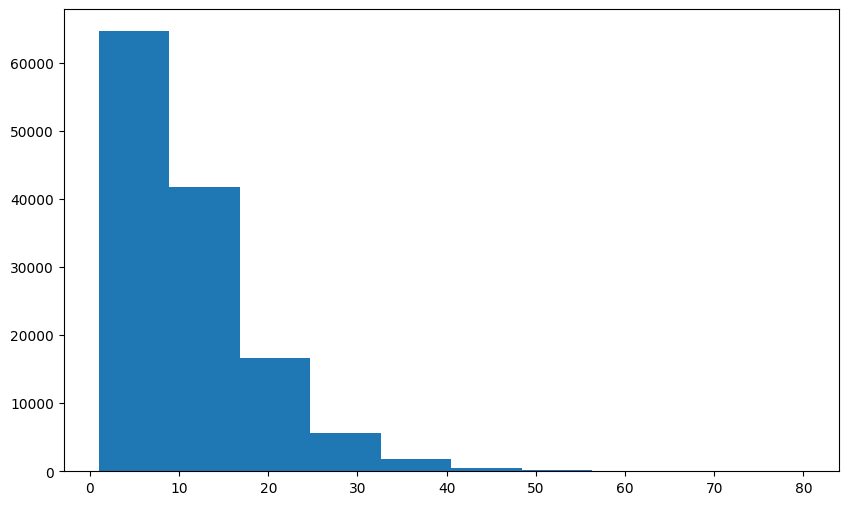

In [26]:
fig = plt.figure(figsize=(10, 6))
plt.hist(results_pd["total_items"])
plt.show()

## Question 7: Find out the names of top 5 most popular products

Hints:
1.   First, join the table "orders" and the table "products" into a single table. Here is the tutorial of [SQL JOIN](https://www.w3schools.com/sql/sql_join.asp).
2.   Then, run [SQL COUNT](https://www.w3resource.com/sql/aggregate-functions/count-with-group-by.php) on the new table. You should use both group by and order by in descending.
3. Then you can run ".show(5)" to display to the top five rows.



In [27]:
# Your code here:

orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

top_products = spark.sql("""
    SELECT p.product_name, COUNT(o.product_id) AS orders_count
    FROM orders o
    JOIN products p ON o.product_id = p.product_id
    GROUP BY p.product_name
    ORDER BY orders_count DESC
    LIMIT 5
""")

top_products.show()

+--------------------+------------+
|        product_name|orders_count|
+--------------------+------------+
|              Banana|       18726|
|Bag of Organic Ba...|       15480|
|Organic Strawberries|       10894|
|Organic Baby Spinach|        9784|
|         Large Lemon|        8135|
+--------------------+------------+

